# Dot Density map

Para la implementación de la técnica *Dot Density Map* y ante la dificultad de localizar en el tiempo disponible un conjunto de datos real que combinara adecuadamente los recuentos necesarios con sus correspondientes geometrías poligonales (límites de áreas), se optó por la generación de datos sintéticos. Esta decisión permitió centrar el esfuerzo en la comprensión y aplicación del algoritmo específico de esta técnica de visualización (generación y ubicación aleatoria de puntos dentro de polígonos basada en recuentos) que era el objetivo principal de esta parte de la práctica.



## Modelo 1

Desde dataset sintético diferente en cada iteracion

Librerías importadas.
GeoDataFrame cargado desde: data_2/reino_imaginario_proyectado.shp
CRS detectado: EPSG:3857
Configuración: Mapeando 'Médicos', 1 punto = 5 unidades.

--- Número de puntos a generar por región ---
         Región  Médicos  num_dots
0        Gondor      120        24
1         Rohan       80        16
2        Mordor       30         6
3        Erebor       50        10
4    La Comarca       20         4
5      Rivendel       40         8
6      Isengard       25         5
7  Minas Tirith       60        12
8    Lothlórien       35         7
9          Dale       45         9
--------------------------------------------
Generando puntos aleatorios para todas las regiones...
Generación completa. Se generaron 101 puntos (esperados: 101).
Creando la visualización del mapa...


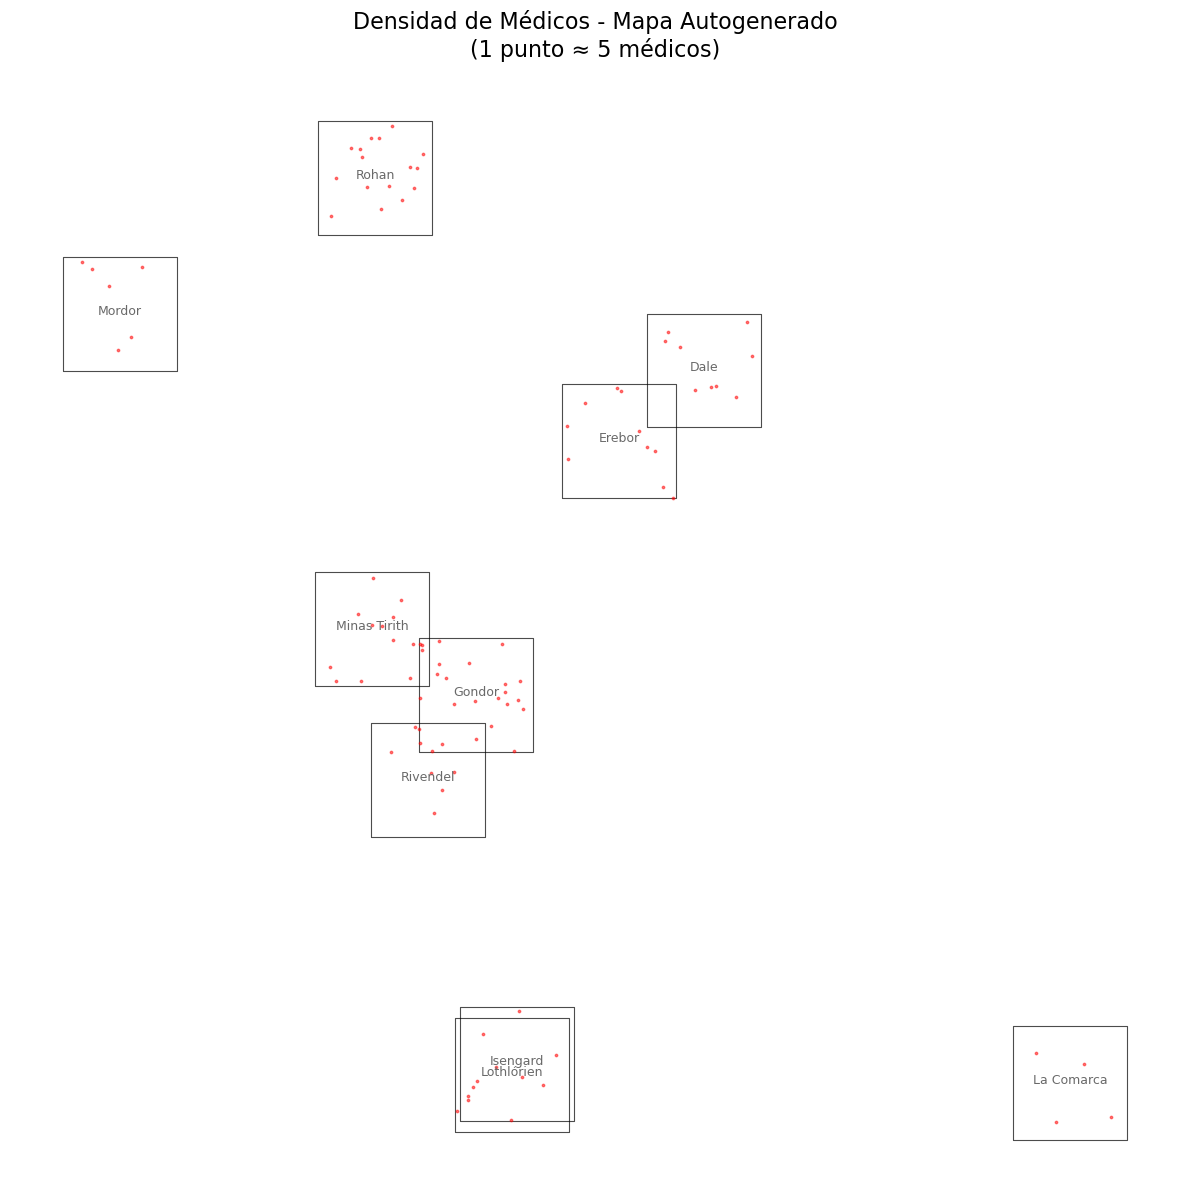

Visualización mostrada.


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np 
from shapely.geometry import Point
import matplotlib.pyplot as plt
#import contextily as ctx # Opcional, para mapa base

print("Librerías importadas.")

# 1: Cargamos el GF de areas

shp_reino_filename = "data_2/reino_imaginario_proyectado.shp"

try:
    gdf_areas = gpd.read_file(shp_reino_filename)
    print(f"GeoDataFrame cargado desde: {shp_reino_filename}")
    print(f"CRS detectado: {gdf_areas.crs}")
    
    # Asegurarnos de que esta en un CRS proyectado (EPSG:3857 web maps)
    if gdf_areas.crs is None or gdf_areas.crs.to_epsg() != 3857:
        print("Reproyectando a EPSG:3857...")
    
        gdf_areas = gdf_areas.to_crs(epsg=3857) 
        print(f"Nuevo CRS: {gdf_areas.crs}")

except Exception as e:
    print(f"Error cargando el Shapefile '{shp_reino_filename}': {e}")
    print("Creando un GeoDataFrame de ejemplo para continuar...")
    gdf_areas = gpd.GeoDataFrame({
       'Región': ['Gondor', 'Rohan', 'Mordor'],
       'Médicos': [120, 80, 30],
       'geometry': [Polygon([(0,0), (0,100000), (100000,100000), (100000,0)]), 
                    Polygon([(200000,0), (200000,100000), (300000,100000), (300000,0)]),
                    Polygon([(0,200000), (0,300000), (100000,300000), (100000,200000)])]
    }, crs="EPSG:3857") 

# 2: Configuración del Dot Density Map
variable_a_mapear = 'Médicos'
dot_value = 5

# Verificamos si la columna existe en GF
if variable_a_mapear not in gdf_areas.columns:
    print(f"Error: La columna '{variable_a_mapear}' no existe en el GeoDataFrame.")
else:
    print(f"Configuración: Mapeando '{variable_a_mapear}', 1 punto = {dot_value} unidades.")

    # 3: Calculamos puntos por área
    gdf_areas[variable_a_mapear] = pd.to_numeric(gdf_areas[variable_a_mapear], errors='coerce').fillna(0)
    
    gdf_areas['num_dots'] = (gdf_areas[variable_a_mapear] / dot_value).round().astype(int)
    
    print("\n--- Número de puntos a generar por región ---")
    print(gdf_areas[['Región', variable_a_mapear, 'num_dots']])
    print("--------------------------------------------")

    # 4: Funcion para generar puntos aleatorios en un polígono
    def generate_random_dots(polygon, num_dots):
        dots = []
        if polygon is None or polygon.is_empty or num_dots <= 0:
            return dots
            
        minx, miny, maxx, maxy = polygon.bounds
        # Evitamos división por cero o bucles infinitos
        if minx == maxx or miny == maxy:
            # print(f"Advertencia: Polígono con área de bounding box 0 encontrado.")
            return dots
            
        attempts = 0
        max_attempts = num_dots * 100

        while len(dots) < num_dots and attempts < max_attempts:
            random_x = np.random.uniform(minx, maxx)
            random_y = np.random.uniform(miny, maxy)
            random_point = Point(random_x, random_y)
            
            # Verifica si el punto aleatorio esta en el polígono
            if polygon.contains(random_point):
                dots.append(random_point)
            attempts += 1
            
        # Advertencia
        if len(dots) < num_dots:
            print(f"Advertencia: Solo se generaron {len(dots)} de {num_dots} puntos para un polígono (intentos: {attempts}). \
                  Verifica el área del polígono.")
            
        return dots

    # 5: Aplicamos la función y recolectamos puntos
    all_dots_geometry = []
    print("Generando puntos aleatorios para todas las regiones...")
    # Iteramos sobre el GF de áreas
    for index, row in gdf_areas.iterrows():
        polygon = row['geometry']
        num_dots_for_area = row['num_dots']
        generated_dots = generate_random_dots(polygon, num_dots_for_area)
        all_dots_geometry.extend(generated_dots)
    
    total_puntos_generados = len(all_dots_geometry)
    total_puntos_esperados = gdf_areas['num_dots'].sum()
    print(f"Generación completa. Se generaron {total_puntos_generados} puntos (esperados: {total_puntos_esperados}).")

    # 6: Creamos un nuevo GDF solo con los puntos generados
    if not all_dots_geometry:
        print("No se generaron puntos, Revisa datos o 'dot_value'.")
    else:
        # mismo CRS que areas
        gdf_dots = gpd.GeoDataFrame(geometry=all_dots_geometry, crs=gdf_areas.crs) 

        # 7: Visualizamos el mapa
        print("Creando la visualización del mapa...")
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))

        # Contornos de areas
        gdf_areas.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.8, alpha=0.7)

        # puntos de densidad
        gdf_dots.plot(ax=ax, marker='.', markersize=12, color='red', alpha=0.5) 

        # nombres de las regiones como etiquetas
        for idx, row in gdf_areas.iterrows():
            # Evita errores si el polígono no tiene un centro
            if row['geometry'].centroid.is_valid:
                 plt.annotate(text=row['Región'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                             horizontalalignment='center', color='dimgray', fontsize=9)


        # Limpieza final y título
        ax.set_axis_off() # Quitamos los ejes X/Y
        plt.title(f"Densidad de {variable_a_mapear} - Mapa Autogenerado\n(1 punto ≈ {dot_value} {variable_a_mapear.lower()})", 
                  fontsize=16, pad=10)
        plt.tight_layout()
        plt.show()
        print("Visualización mostrada.")

## Modelo 2

Generación totalmente aleatoria de puntos en un Layout en forma de grilla.

--> Librerías listas.
--> GeoDataFrame 'gdf_areas' creado con 10 regiones y CRS: EPSG:3857
--> Configuración lista: Visualizando 'Médicos', 1 punto = 5 unidades.
--> Generando puntos aleatorios...
--> Generación completa. Total puntos creados: 101.
--> Creando la visualización...
--> Gráfico guardado como 'dot_density_generated_map.png'!


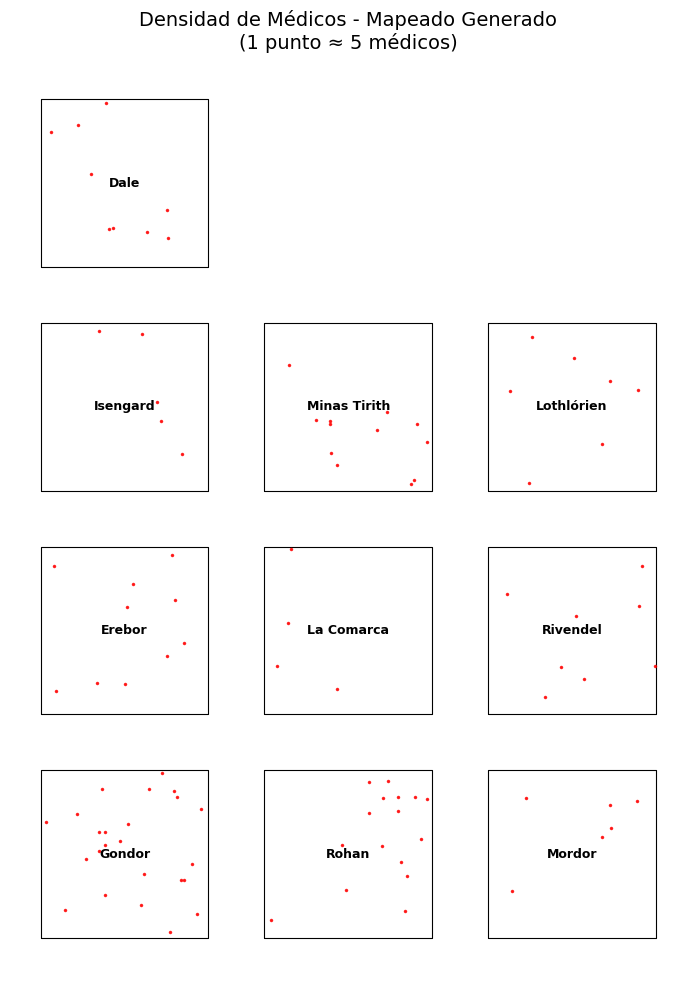

--> Visualización deDot Density Point.


In [4]:
# 1.importamos las librerías
import geopandas as gpd
import pandas as pd
import numpy as np 
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
# import contextily as ctx 

print("--> Librerías listas.")

# 1: Definimos nuestros datos y creamos areas del reino

# Datos de nuestro reino imaginario
regiones = [
    "Gondor", "Rohan", "Mordor", "Erebor", "La Comarca", 
    "Rivendel", "Isengard", "Minas Tirith", "Lothlórien", "Dale"
]
# Asignamos un número de médicos inventado
medicos = [120, 80, 30, 50, 20, 40, 25, 60, 35, 45]
# Podríamos añadir otras columnas como 'Guerreros'

# Layout en cuadrícula para que no se solapen las regiones ---
num_regiones = len(regiones)
num_cols = 3 # 3 cols

# Calculamos filas necesarias para acomodar todas las regiones
num_rows = int(np.ceil(num_regiones / num_cols)) 

# Definimos el tamaño de nuestros cuadrados (regiones) y cuánto espacio habrá entre ellos
# Usamos metros porque trabajaremos con un CRS proyectado (EPSG:3857)
polygon_half_size = 150000  # 300km de lado (150km desde el centro)
spacing = 400000         # 400km entre centros

# coordenadas del centro para cada región en la cuadrícula
centers_x = []
centers_y = []
for i in range(num_regiones):
    col = i % num_cols
    row = i // num_cols
    # posición X e Y basándonos en la columna la fila y el espaciado
    centers_x.append(col * spacing + polygon_half_size) 
    centers_y.append(row * spacing + polygon_half_size)

# Df de pandas temporal con esta información
df_reino_temp = pd.DataFrame({
    'Región': regiones,
    'Médicos': medicos,
    'center_x': centers_x,
    'center_y': centers_y
    
})

# cuadrado (Polygon) centrado en (x, y) y size concreto
def generar_poligono_proyectado(x, y, size):
    # Creamos los 4 vértices del cuadrado
    return Polygon([
        (x - size, y - size), (x - size, y + size),
        (x + size, y + size), (x + size, y - size),
        (x - size, y - size)
    ])

# geometria (los cuadrados) para cada región
geometries = [generar_poligono_proyectado(x, y, polygon_half_size) 
              for x, y in zip(df_reino_temp['center_x'], df_reino_temp['center_y'])]

# Creamos GDF final con regiones los datos y las geometrías
# Le asignamos CRS proyectado EPSG:3857 porque hemos calculado todo en metros
gdf_areas = gpd.GeoDataFrame(df_reino_temp, geometry=geometries, crs="EPSG:3857") 

# Eliminamos las columnas x e y del centro
gdf_areas = gdf_areas.drop(columns=['center_x', 'center_y'])

print(f"--> GeoDataFrame 'gdf_areas' creado con {len(gdf_areas)} regiones y CRS: {gdf_areas.crs}")


# 2: Configuración mapa de densidad
variable_a_mapear = 'Médicos' # Variable a mapear
dot_value = 5             # Médicosxpuntos

# Comprobamos que la variable exista para evitar errores
if variable_a_mapear not in gdf_areas.columns:
    print(f"La columna '{variable_a_mapear}' no figura.")
else:
    print(f"--> Configuración lista: Visualizando '{variable_a_mapear}', 1 punto = {dot_value} unidades.")

    # 3: Calculamos cuantos puntos dibujar en cada region
    # Aseguramos que la columna de la variable sea numerica
    gdf_areas[variable_a_mapear] = pd.to_numeric(gdf_areas[variable_a_mapear], errors='coerce').fillna(0)
    # puntos redondeando
    gdf_areas['num_dots'] = (gdf_areas[variable_a_mapear] / dot_value).round().astype(int)
    
    # Resumen de puntos por region
    # print("\n--- Puntos a generar por region ---")
    # print(gdf_areas[['Región', variable_a_mapear, 'num_dots']])
    # print("-------------------------------------")

    # 4: Función mágica para generar puntos aleatorios dentro de un polígono
    def generate_random_dots(polygon, num_dots):
        # puntos al azar dentro del 'polygon'
        dots = []
        if polygon is None or polygon.is_empty or num_dots <= 0:
            return dots
            
        minx, miny, maxx, maxy = polygon.bounds # limites del poligono
        if minx == maxx or miny == maxy: 
            return dots 
            
        attempts = 0
        max_attempts = num_dots * 150 # Intentos

        # Seguimos intentando hasta tener los puntos necesarios o agotar los intentos
        while len(dots) < num_dots and attempts < max_attempts:
            # Generamos un punto (x, y) al azar dentro del rectángulo que rodea al polígono
            random_point = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
            # Comprobamos si ese punto aleatorio cae dentro del polígono
            if polygon.contains(random_point):
                dots.append(random_point) # if yes -> a lista
            attempts += 1
            
        # Si despues de muchos intentos no conseguimos todos los puntos:
        # if len(dots) < num_dots: 
        #     print(f"Advertencia: Solo se generaron {len(dots)}/{num_dots} puntos.")
            
        return dots #lista de puntos dentro

    # 5: Generamos y juntamos todos los puntos de todas las regiones
    all_dots_geometry = [] # puntos generados
    print("--> Generando puntos aleatorios...")
    # Recorremos cada región de nuestro GDF
    for index, row in gdf_areas.iterrows():
        # Llamamos a función para generar los puntos
        generated_dots = generate_random_dots(row['geometry'], row['num_dots'])
        # añadimos los puntos generados para esta región a la lista total
        all_dots_geometry.extend(generated_dots) 
    
    total_puntos_generados = len(all_dots_geometry)
    print(f"--> Generación completa. Total puntos creados: {total_puntos_generados}.")

    # 6: Creamos un GDF solo con los puntos
    if not all_dots_geometry:
        print("No se generaron puntos. Revisar datos o 'dot_value'.")
    else:
        # Creamos el GF de puntos asignándole =CRS que áreas
        gdf_dots = gpd.GeoDataFrame(geometry=all_dots_geometry, crs=gdf_areas.crs) 

        # 7: Dibujamos el mapa
        print("--> Creando la visualización...")
        fig, ax = plt.subplots(1, 1, figsize=(10, 10)) # figura y ejes

        # contornos de regiones (cuadrados)
        gdf_areas.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.8)
        
        # Dibujamos encima todos los puntos rojos de densidad

        gdf_dots.plot(ax=ax, marker='.', markersize=9, color='red', alpha=0.8, label='Puntos de Densidad', zorder=2)
        # Añadimos una leyenda 
        
        # Añadimos el nombre de cada region cerca de su centro
        for idx, row in gdf_areas.iterrows():
            # Comprobamos que el centroide sea válido antes de poner la etiqueta
            if row['geometry'].centroid.is_valid:
                 plt.annotate(text=row['Región'], 
                              xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                              horizontalalignment='center', 
                              verticalalignment='center', 
                              color='black',
                              fontsize=9, 
                              fontweight='bold')

        # Quitamos los ejes X e Y 
        ax.set_axis_off() 
        # ejes con la misma escala para que los cuadrados no se deformen
        ax.set_aspect('equal') 
        # Ponemos un titulo
        plt.title(f"Densidad de {variable_a_mapear} - Mapeado Generado\n(1 punto ≈ {dot_value} {variable_a_mapear.lower()})", 
                  fontsize=14) 
        # Ajustamos para que no se corte
        plt.tight_layout() 
        
        # 8: Guardamos el grafico como imagen
        output_filename = "dot_density_generated_map.png"
        try:
            fig.savefig(output_filename, dpi=300, bbox_inches='tight')
            print(f"--> Gráfico guardado como '{output_filename}'!")
        except Exception as e:
            print(f"Error al guardar el gráfico: {e}")

        # mostramos el grafico en pantalla
        plt.show()
        print("--> Visualización deDot Density Point.")